In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import scipy.io as io
from mpl_toolkits import mplot3d
import xarray as xr
import pandas as pd
import matplotlib as mpl
import h5py

In [2]:
path='/Users/zcaspar/Documents/Stage/grl/Data'

In [361]:
#Taille labels, legend des figures:
Size=18
mpl.rcParams['axes.labelsize']=Size
mpl.rcParams['xtick.labelsize']=Size
mpl.rcParams['ytick.labelsize']=Size
mpl.rcParams['legend.fontsize']=Size

In [77]:

#Extraction data: 

f['day'][:]



def Combine_debfin(moor,var):
    """combine données 1ere et dernière année de mesures mouillages A,B et D """
    if moor=='A':
        t=xr.DataArray(var[0],[('time',dA),('pressure',PA)])
        t1=xr.DataArray(var[1],[('time',dA1+1.5*365.),('pressure',PA1)])
    elif moor=='B':
        t=xr.DataArray(var[0],[('time',dB),('pressure',PB)])
        t1=xr.DataArray(var[1],[('time',dB1+1.5*365.),('pressure',PB1)])
    elif moor=='D':
        t=xr.DataArray(var[0],[('time',dD+2*365),('pressure',PD)])
        t1=xr.DataArray(var[1],[('time',dD1+3.5*365.),('pressure',PD1)])
    Tt=t.combine_first(t1)
    #Tt=Tt.resample(time='2D').asfreq()
    dd=Tt.coords['time'].values
    p=Tt.coords['pressure'].values
    return Tt,dd,p

def plot3d(moor,var,figsize,k):
    """plot 3D des données des 1ere et dernière années de mesures aux mouillages A,B et D.Prend en entrée le mouillage concerné, la variable voulue, la taille de la figure et tous les combien un profil sera tracé"""
    p=var.coords['pressure']
    D=var.coords['time'].values

    plt.figure(figsize=figsize)
    ax=plt.axes(projection='3d')

    for j in range(var.coords['time'].size):
        if j%k==0:
            dj=var.coords['time'].values[j]
            ax.plot(var.sel(time=dj,method='nearest').sel(pressure=slice(300,700)).where(var.sel(time=dj,method='nearest').sel(pressure=slice(300,700))>27.8),p.sel(pressure=slice(300,700)),dj,'k',zdir='y');ax.set_zlim([700,300])
    ax.set_xlabel('\n\nDensity (kg.m$^{-3}$)');ax.set_ylabel('Time',labelpad=40,rotation=40);ax.set_zlabel('\nPressure(dbar)')
    #ax.tick_params(axis='y',pad=40)
    if moor=='A':
        #emplacements des ticks sur l'axe du temps (y)
        Y=np.linspace(D.min(),dA.max(),5)#
        Y=np.concatenate((Y,np.linspace(DA[np.where(DA==dA.max())[0][0]+1],DA.max(),5)))#np.linspace(830,1176,5)))
        #
        Time=np.linspace(D.min(),dA.max(),5)#578,5)
        Time=np.concatenate((Time,np.linspace(dA1.min()+13*365,dA1.max()+13*365,5)))#np.linspace(5027,5375,5)))
    if moor=='B':
        Y=np.linspace(D.min(),dB.max(),5)#578,5)
        Y=np.concatenate((Y,np.linspace(DB[np.where(DB==dB.max())[0][0]+1],DB.max(),5)))#np.linspace(830,1176,5)))
        Time=np.linspace(D.min(),dB.max(),5)#578,5)
        Time=np.concatenate((Time,np.linspace(dB1.min()+14*365,dB1.max()+14*365,5)))
    if moor=='D':
        Y=np.linspace(D.min(),dD.max()+2*365,5)#578,5)
        Y=np.concatenate((Y,np.linspace(DD[np.where(DD==dD.max()+2*365)[0][0]+1],DD.max(),5)))#np.linspace(830,1176,5)))
        Time=np.linspace(D.min(),dD.max()+2*365,5)#578,5)
        Time=np.concatenate((Time,np.linspace(dD1.min()+14*365,dD1.max()+14*365,5)))
        
    lab=pd.to_datetime(Time,unit='D',origin='2003-01-01').strftime('%m-%y')
    ax.set_yticks(Y)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_yticklabels(lab)
    ax.get_yticklabels()[5].set_color('red')
    ax.get_yticklabels()[4].set_color('red')
    ax.set_xlim(left=27.8)
    #plt.yticks(ha='left')
    plt.setp(ax.yaxis.get_majorticklabels(),rotation=-25,ha='left',rotation_mode='anchor')
    plt.setp(ax.xaxis.get_majorticklabels(),rotation=15,ha='center',rotation_mode='anchor')
    return Y

In [4]:
#lecture fichiers .mat
file=[path+'/bg0304_mmp_a.mat',path+'/bg1617_mmp_a.mat']
d0='2003-01-01'

fa=io.loadmat(file[0])
fa1=h5py.File(file[1])

fileb=[path+'/bg0304_mmp_b.mat',path+'/bg1718_mmp_b.mat']

fb=io.loadmat(fileb[0])
fb1=h5py.File(fileb[1])

filed=[path+'/bg0506_mmp_d.mat',path+'/bg1718_mmp_d.mat']

fd=io.loadmat(filed[0])
fd1=h5py.File(filed[1])

In [5]:
#extraction des données
Siga=vari(fa)[2]
dA=vari(fa)[-2]
PA=vari(fa)[-3]
Siga1=vari_v7(fa1)[2]
dA1=vari_v7(fa1)[-2]
PA1=vari_v7(fa1)[-3]

Sigb=vari(fb)[2]
dB=vari(fb)[-2]
PB=vari(fb)[-3]
Sigb1=vari_v7(fb1)[2]
dB1=vari_v7(fb1)[-2]
PB1=vari_v7(fb1)[-3]

Sigd=vari(fd)[2]
dD=vari(fd)[-2]
PD=vari(fd)[-3]
Sigd1=vari_v7(fd1)[2]
dD1=vari_v7(fd1)[-2]
PD1=vari_v7(fd1)[-3]


### Plot of the first and last years of data for moorings A, B and D

Text(0.5, 0.92, 'Mooring A : Differences first year/last year ')

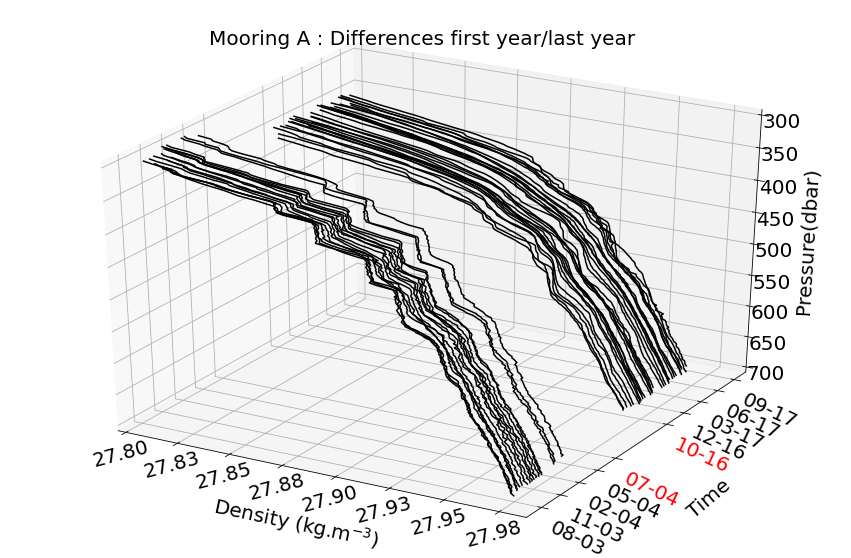

In [42]:
#Combinaison et plot :
siga=[Siga,Siga1]
SigA,DA=Combine_debfin('A',siga)[:2]
Y=plot3d('A',SigA,(15,10),10)
plt.title('Mooring A : Differences first year/last year ',size=Size)

Text(0.5, 0.92, 'Mooring D : Differences first year/last year ')

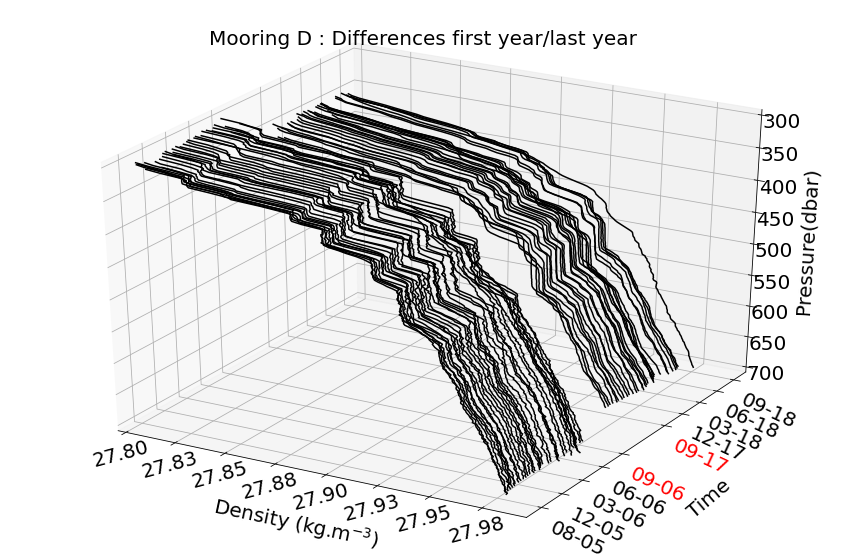

In [41]:
sigd=[Sigd,Sigd1]
SigD,DD=Combine_debfin('D',sigd)[:2]
Y=plot3d('D',SigD,(15,10),10)
plt.title('Mooring D : Differences first year/last year ',size=Size)

Text(0.5, 0.92, 'Mooring B : Differences first year/last year ')

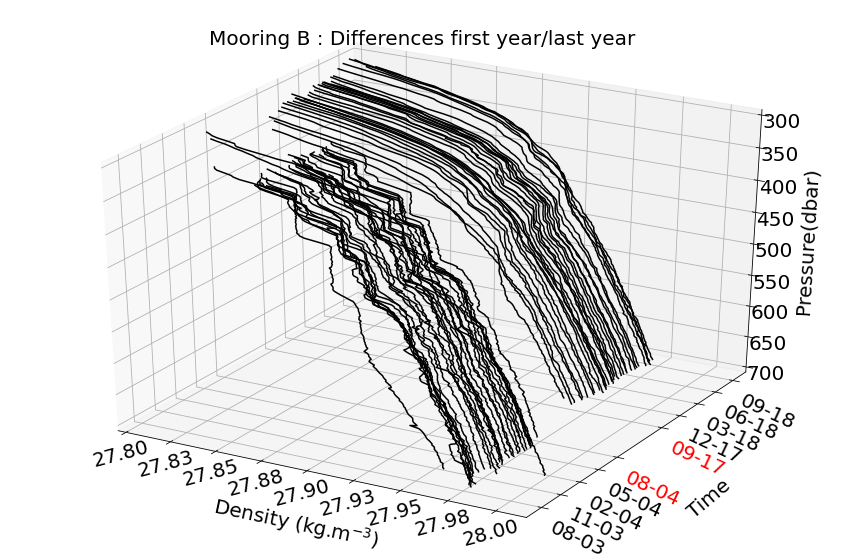

In [40]:
sigb=[Sigb,Sigb1]
SigB,DB=Combine_debfin('B',sigb)[:2]
Y=plot3d('B',SigB,(15,10),10)
plt.title('Mooring B : Differences first year/last year ',size=Size)

In [363]:
def genfig_3d(var,figsize,k,origin):
    """plot 3D des données des 1ere et dernière années de mesures aux mouillages A,B et D.Prend en entrée le mouillage concerné, la variable voulue, la taille de la figure et tous les combien un profil sera tracé"""
    p=var.coords['pressure']
    D=var.coords['time'].values

    plt.figure(figsize=figsize)
    ax=plt.axes(projection='3d')

    for j in range(var.coords['time'].size):
        if j%k==0:
            dj=var.coords['time'].values[j]
            ax.plot(var.sel(time=dj,method='nearest').sel(pressure=slice(300,700)).where(var.sel(time=dj,method='nearest').sel(pressure=slice(300,700))>27.8),p.sel(pressure=slice(300,700)),dj,'k',zdir='y');ax.set_zlim([700,300])
    ax.set_xlabel('\n\nDensity (kg.m$^{-3}$)');ax.set_ylabel('Time (month-year)',labelpad=40,rotation=40);ax.set_zlabel('\nPressure(dbar)')
    #ax.tick_params(axis='y',pad=40)
    #emplacements des ticks sur l'axe du temps (y)
    Time=np.linspace(D.min(),D.max(),10)#578,5)
    
        #Y=np.linspace(D.min(),dD.max()+2*365,5)#578,5)
    lab=pd.to_datetime(Time,unit='D',origin=origin).strftime('%m-%y')
    #ax.set_yticks(Y)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_yticklabels(lab)
#    ax.get_yticklabels()[5].set_color('red')
#    ax.get_yticklabels()[4].set_color('red')
    ax.set_xlim(left=27.8)
    #plt.yticks(ha='left')
    plt.setp(ax.yaxis.get_majorticklabels(),rotation=-25,ha='left',rotation_mode='anchor')
    plt.setp(ax.xaxis.get_majorticklabels(),rotation=15,ha='center',rotation_mode='anchor')
    return D

Text(0.5, 0.92, 'Data from year 2006/2007 at mooring D')

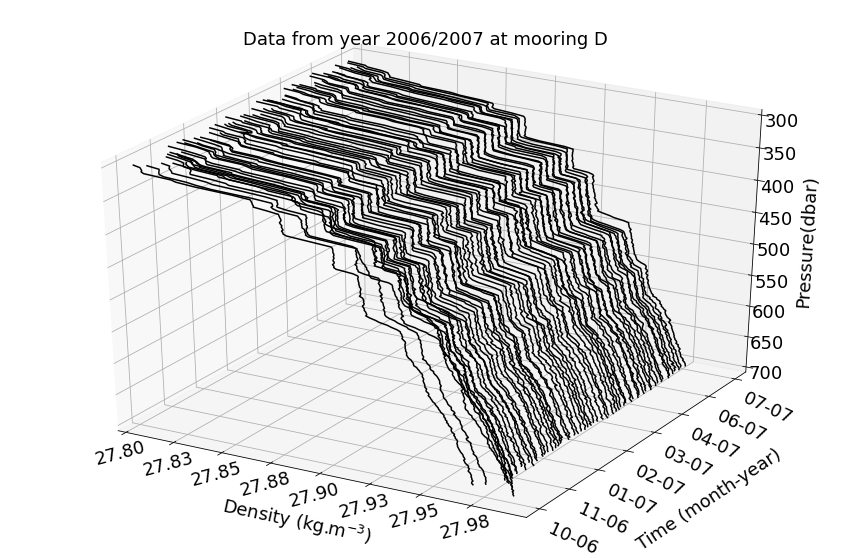

In [364]:
#Mooring D:
fileD = path+'/bg0607_mmp_d.mat'
fD = io.loadmat(fileD)
sig_D = vari(fD)[2]
T_D = vari(fD)[0]
S_D = vari(fD)[1]
xx = genfig_3d(sig_D,(15,10),5,'2006-01-01')
plt.title('Data from year 2006/2007 at mooring D',size=Size)

### Plot mean profiles of year 2006/2007 at mooring D + snapshots at mid time series (Fig1c)

In [17]:
#Mean :
Sigmean_D = sig_D.mean(axis=0)
Smean_D = S_D.mean(axis=0)
Tmean_D = T_D.mean(axis=0)

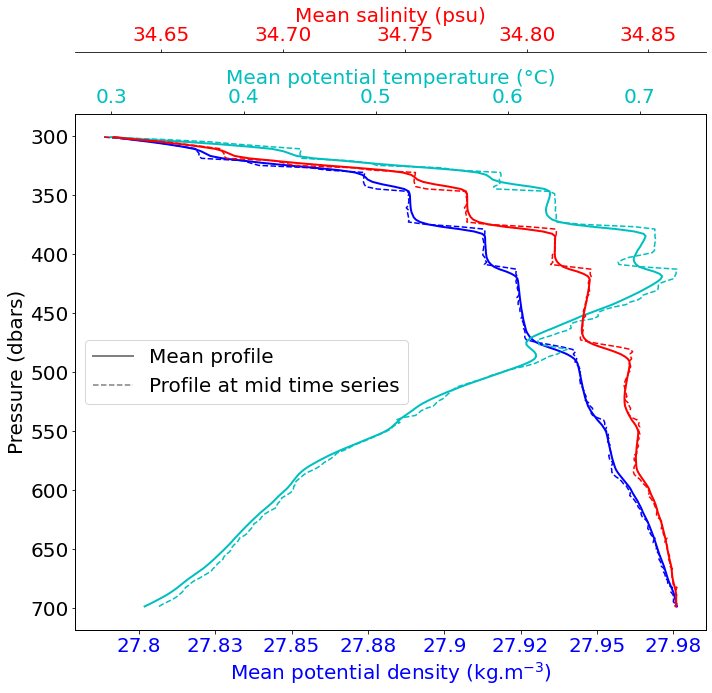

In [52]:
fig,ax=plt.subplots(figsize=(10,10))
Sigmean_D.sel(pressure=slice(300,700)).plot(ax=ax,y='pressure',yincrease=False,c='b',linewidth=2)
sig_D.isel(time=sig_D.time.size//2).sel(pressure=slice(300,700)).plot(ax=ax,y='pressure',yincrease=False,c='b',linestyle='--')
ax.set_xlabel(r'Mean potential density (kg.m$^{-3}$)',color='b');ax.set_ylabel('Pressure (dbars)')
lab = np.around(ax.get_xticks(),decimals=2)
ax.set_xticklabels(lab,color='b')
#ax.tick_params(axis='x', labelcolor='b')

ax1 = ax.twiny()
Tmean_D.sel(pressure=slice(300,700)).plot(ax=ax1,y='pressure',yincrease=False,c='c',linewidth=2)
T_D.isel(time=T_D.time.size//2).sel(pressure=slice(300,700)).plot(ax=ax1,y='pressure',yincrease=False,c='c',linestyle='--')


ax1.tick_params(axis='x', labelcolor='c')
ax1.set_xlabel(r'Mean potential temperature (°C)',color='c')

ax2 = ax.twiny()
ax2.spines["top"].set_position(("axes", 1.12))
ax2.spines["top"].set_visible(True)

Smean_D.sel(pressure=slice(300,700)).plot(ax=ax2,y='pressure',yincrease=False,c='r',linewidth=2)
S_D.isel(time=S_D.time.size//2).sel(pressure=slice(300,700)).plot(ax=ax2,y='pressure',yincrease=False,c='r',linestyle='--')


ax2.tick_params(axis='x', labelcolor='r')
ax2.set_xlabel(r'Mean salinity (psu)',color='r')
#ax2.xaxis(r'Salinity (psu)',color='r',offset=30)
fig.tight_layout()
ax2.set_title('');ax1.set_title('');ax.set_title('')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='grey', lw=2),
                Line2D([0], [0], color='grey',linestyle='--' )]

ax.legend(custom_lines, ['Mean profile', 'Profile at mid time series'],loc=6)
#ax.set_legend(custom_lines,labels)

### Plot TS diagram of mean salinity and temperature

(0.2, 0.8)

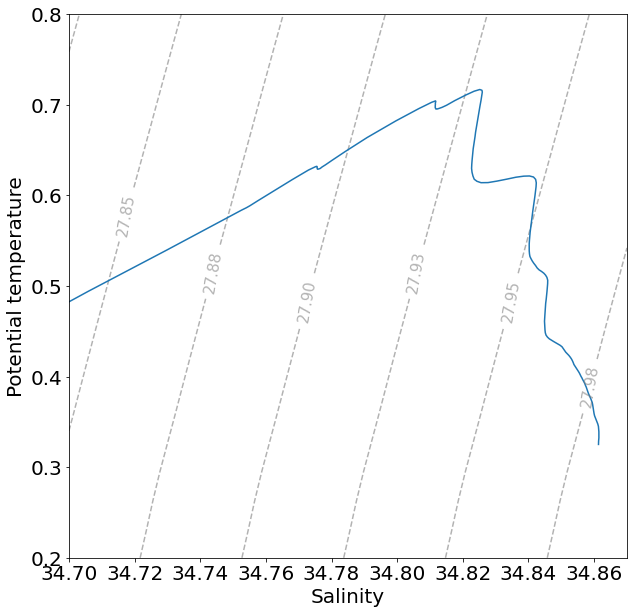

In [53]:
#TS diagram:
import numpy as np
import gsw
slim=[34.7,34.87]
tlim=[0.2,0.8]
P = Smean_D.coords['pressure'].values
SAmean = gsw.SA_from_SP(Smean_D,P,-150,74)

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(Smean_D.sel(pressure=slice(300,700)),Tmean_D.sel(pressure=slice(300,700)))
trange=np.linspace(tlim[0],tlim[1],20)#(tmin,tmax,20)
Srange=np.linspace(slim[0],slim[1],20)#(Smin,Smax,20)
Prange=np.linspace(300,700,20)

tinter,Sinter=np.meshgrid(trange,Srange)
sal_abs=gsw.SA_from_SP(Sinter,Prange,-145,76.5)
CT=gsw.CT_from_t(sal_abs,tinter,Prange)
Rho=gsw.sigma0(sal_abs,CT)
#plt.figure(figsize=(15,15))
cs=plt.contour(Sinter,tinter,Rho,linestyles='--',colors='gray',alpha=0.6)
plt.clabel(cs, fontsize=15, inline=True, fmt='%0.2f')
plt.xlabel('Salinity');plt.ylabel('Potential temperature')
plt.xlim(slim);plt.ylim(tlim)

### Plot velocities and density profiles at mooring B (Fig2)

In [88]:
import glob
fileb=np.sort(glob.glob(path+'/*mmp_b*.mat'))


In [511]:
import datetime
def read_moors(file):
    """extrait les données de temperature potentielle, salinité, vitesses, densité, pression, temps et température in situ des fichiers de mouillages"""
    try: 
        f = io.loadmat(file)
    except:
        f = h5py.File(file)
    if len(f.keys())==0:
        pass
    else:
        p=f['pgrid'][:].reshape((f['pgrid'][:].size,))
        d=f['day'][:].reshape((f['day'][:].size,))
        origin = '20'+file[-14:-12]+'-01-01'
        time = pd.to_datetime(d,unit='D',origin=origin)
        T=xr.DataArray(f['THETA'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
        S=xr.DataArray(f['S'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
        u=xr.DataArray(f['U'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
        v=xr.DataArray(f['V'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
        sig=xr.DataArray(f['SIGTH'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
        t=xr.DataArray(f['T'][:].reshape((d.size,p.size)),[('time',time),('pressure',p)])
        T.name='Potential_temperature'
        S.name='Salinity'
        sig.name='Density'
        u.name = 'u'
        v.name = 'v'
        U=np.sqrt(u**2+v**2)
        U.name = 'Velocity_magnitude'
     #   tst = xr.Dataset({'%s'%ds.name:ds for ds in [T,S,sig,u,v,U]})
        return xr.Dataset({'%s'%ds.name:ds for ds in [T,S,sig,u,v,U]})



In [512]:
list_moorB = [read_moors(fil) for fil in fileb if read_moors(fil)]

In [513]:
Ds = xr.concat([read_moors(fil) for fil in fileb if read_moors(fil)],dim='time')

In [514]:
t0 = datetime.datetime(2003,8,1)
t1 = datetime.datetime(2004,8,31)
p0,p1 = 250,700
dsi = Ds.sel(time=slice(t0,t1),pressure=slice(p0,p1))

In [546]:
t_tbs = dsi.Velocity_magnitude.where(dsi.Velocity_magnitude>15,drop=True).time.values

### Plot Fig2a:

Comment : A profile over 4 are plotted (except in detected eddies)


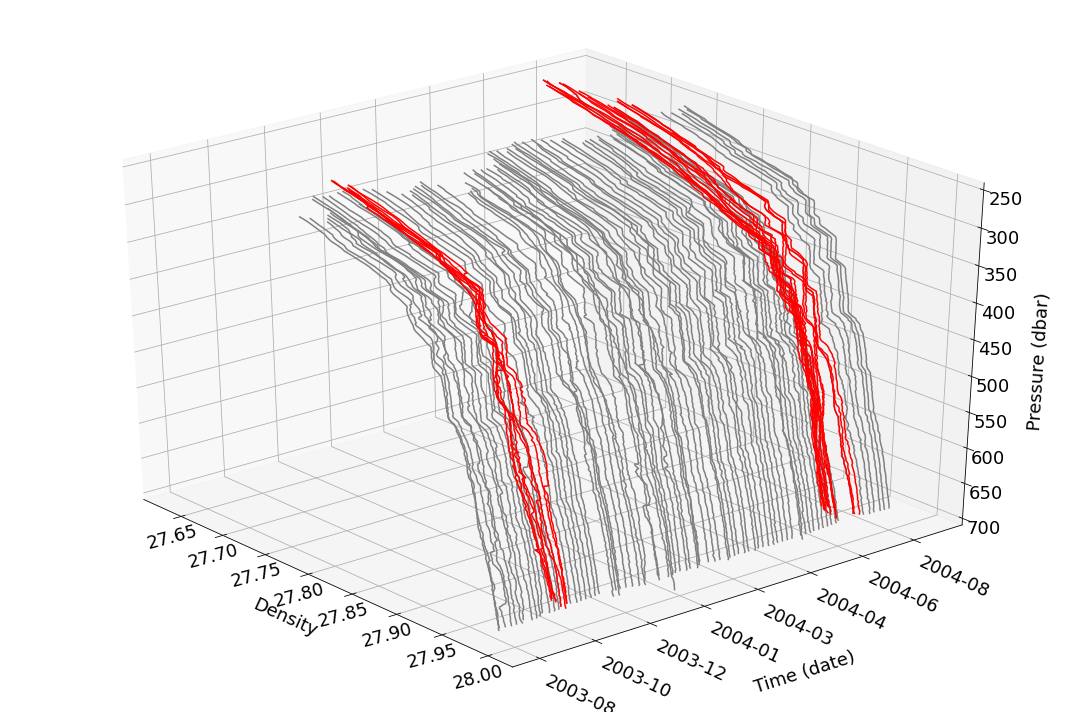

In [557]:
import matplotlib.dates as dates
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111,projection='3d')
tps = []
for t in dsi.time.values[::4]:
    ax.plot(dsi.Density.sel(time=t).values.reshape(dsi.sel(time=t).pressure.values.size,1),
            dsi.sel(time=t).pressure.values.reshape(dsi.sel(time=t).pressure.values.size,1),
            dates.date2num(t),'grey',zdir='y'
            )
    tps.append(str(t)[:10])
ax.set_zlim(p1,p0)
#ax.set_yticks(Y)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
y = ax.get_yticks()
ax.set_yticklabels([dates.num2date(Y).strftime('%Y-%m') for Y in y])
plt.setp(ax.yaxis.get_majorticklabels(),rotation=-25,ha='left',rotation_mode='anchor');
plt.setp(ax.xaxis.get_majorticklabels(),rotation=15,ha='center',rotation_mode='anchor');
fig.tight_layout()
ax.set_xlabel('Density',labelpad=15);ax.set_ylabel('Time (date)',labelpad=50);
ax.set_zlabel('Pressure (dbar)',labelpad=15)
ax.view_init(30,-40)
for t in t_tbs:
    ax.plot(dsi.Density.sel(time=t).values.reshape(dsi.sel(time=t).pressure.values.size,1),
            dsi.sel(time=t).pressure.values.reshape(dsi.sel(time=t).pressure.values.size,1),
            dates.date2num(t),'r',zdir='y'
            )
print('Comment : A profile over 4 are plotted (except in detected eddies)')

### Fig2b

In [554]:
t_tbs

array(['2003-10-26T12:00:00.000000000', '2003-10-26T18:00:00.000000000',
       '2003-10-28T18:00:00.000000000', '2003-10-29T00:00:00.000000000',
       '2003-10-31T00:00:00.000000000', '2003-10-31T06:00:00.000000000',
       '2003-11-02T06:00:00.000000000', '2003-11-02T12:00:00.000000000',
       '2004-07-15T18:00:00.000000000', '2004-07-15T22:59:59.999971200',
       '2004-07-17T22:59:59.999971200', '2004-07-18T04:59:59.999971200',
       '2004-07-20T06:00:00.000000000', '2004-07-20T10:59:59.999971200',
       '2004-07-22T10:59:59.999971200', '2004-07-22T16:59:59.999971200',
       '2004-07-24T18:00:00.000000000', '2004-07-26T22:59:59.999971200',
       '2004-07-27T04:59:59.999971200', '2004-07-29T06:00:00.000000000',
       '2004-07-29T10:59:59.999971200', '2004-07-31T12:00:00.000000000',
       '2004-07-31T16:59:59.999971200', '2004-08-02T16:59:59.999971200'],
      dtype='datetime64[ns]')

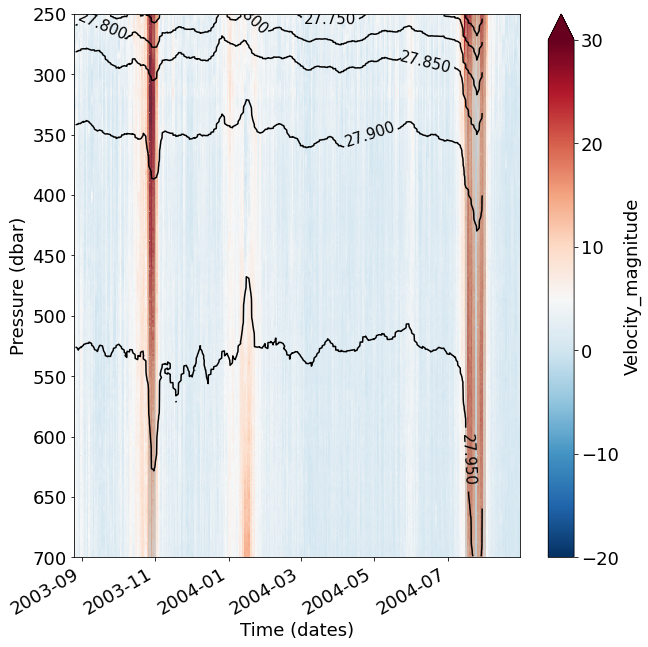

In [561]:
a0 = datetime.datetime(2003,10,26)
a1 = datetime.datetime(2003,11,2)
b0 = datetime.datetime(2004,7,15)
b1 = datetime.datetime(2004,8,2)
fig= plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
Ds['Velocity_magnitude'].sel(time=slice(datetime.datetime(2003,7,31),datetime.datetime(2004,8,31)),pressure=slice(250,700)).plot(ax=ax,y='pressure',yincrease=False,cmap='RdBu_r',vmin=-20,vmax=30,label='Velocity')
cs = Ds['Density'].sel(time=slice(datetime.datetime(2003,8,1),datetime.datetime(2004,8,1)),pressure=slice(250,700)).rolling(time=6, center=True).mean().dropna("time").plot.contour(ax=ax,colors='k',levels=8,y='pressure',yincrease=False)
plt.clabel(cs,inline=True,fontsize=15)
#ax.set_yticks(dates.date2num(datetime.datetime(2003,7,31)),dates.date2num(datetime.datetime(2003,8,31))
ax.set_ylabel('Pressure (dbar)');ax.set_xlabel('Time (dates)')
plt.axvspan(a0, a1, color='grey', alpha=0.3, lw=0)
plt.axvspan(b0, b1, color='grey', alpha=0.3, lw=0)
#var.plot(ax=ax)